In [1]:
%reload_kedro

2020-06-07 22:47:49,534 - root - INFO - ** Kedro project Immunization Drop-outs
2020-06-07 22:47:49,535 - root - INFO - Defined global variable `context` and `catalog`


## Patients

Data Dictionary: patients_db.csv
* pat_id: The unique ID of the child.
* dob: The date of birth of the child.
* gender: The gender of the child.
* fac_id: The unique ID of the health facility the child received the vaccination.
* lat: The latitude of the facility.
* long: The longitude of the facility.
* district: The geographical district that the facility is located in.

In [2]:
dfp = catalog.load("patients")
dfp.head()

2020-06-07 22:47:49,540 - kedro.io.data_catalog - INFO - Loading data from `patients` (CSVDataSet)...


,Unnamed: 0,pat_id,fac_id,dob,gender,long,lat,region,district
0,0,1,51.0,2019-01-22,f,NaN,NaN,Ghanzi,Ghanzi
1,1,2,89.0,2019-11-12,f,24.877556,-18.370709,Chobe,Chobe
2,2,3,161.0,2019-11-03,m,25.249672,-20.490189,Central,Tutume
3,3,4,168.0,2019-04-17,f,25.579269,-21.412151,Central,Lethlakane
4,4,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli


In [3]:
def remove_unnamed_column_patients(df):
    """
    Remove columns leftover by df to csv conversion.
    """
    return df.drop('Unnamed: 0', 1)

In [4]:
dfp = remove_unnamed_column_patients(dfp)
dfp.shape

(50000, 8)

In [5]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pat_id    50000 non-null  int64  
 1   fac_id    47496 non-null  float64
 2   dob       50000 non-null  object 
 3   gender    48998 non-null  object 
 4   long      47464 non-null  float64
 5   lat       47464 non-null  float64
 6   region    48366 non-null  object 
 7   district  48366 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 3.1+ MB


In [6]:
dfp.dtypes

pat_id        int64
fac_id      float64
dob          object
gender       object
long        float64
lat         float64
region       object
district     object
dtype: object

In [7]:
def convert_to_date(df):
    df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d')
    return df

In [8]:
import pandas as pd

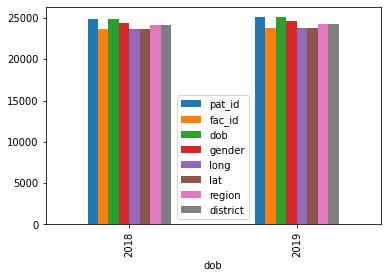

In [9]:
dfp = convert_to_date(dfp)
dfp.groupby(dfp["dob"].dt.year).count().plot(kind="bar")

Dates look ok.

Check if we have duplicate records.

In [10]:
len(dfp.pat_id.unique()) == dfp.shape[0]

True

Check for NaNs.

In [11]:
dfp.isnull().values.any()

True

In [12]:
dfp.isnull().sum().sum()

11846

In [13]:
dfp['dob'].isnull().sum()

0

In [14]:
dfp['gender'].isnull().sum()

1002

I will exclude records without gender from the dataset as I will be using it as a predictor.

In [15]:
dfp['fac_id'].isnull().sum()

2504

Facility ID column has a lot of nulls. Lets see if we can fill the missing information using other records.

How many facilities we have in the database?

In [16]:
len(dfp['fac_id'].unique())

346

In [17]:
len(dfp['region'].unique())

16

In [18]:
# list of facilities
fac_list = dfp['fac_id'].unique()
# region list
region_list = dfp['region'].unique()

In [19]:
dffac = dfp.drop(['pat_id', 'dob', 'gender'], 1)
# dftemp = dftemp[dftemp.region == region_list[0]]
dffac.head()

,fac_id,long,lat,region,district
0,51.0,NaN,NaN,Ghanzi,Ghanzi
1,89.0,24.877556,-18.370709,Chobe,Chobe
2,161.0,25.249672,-20.490189,Central,Tutume
3,168.0,25.579269,-21.412151,Central,Lethlakane
4,183.0,28.487746,-22.571451,Central,Tuli


In [20]:
dffac.shape

(50000, 5)

In [21]:
# sort fac_id - ascending order
dffac.sort_values(by=['fac_id'], inplace=True)
dffac.head()

,fac_id,long,lat,region,district
36903,1.0,NaN,NaN,North-West,Ngamiland East
37931,1.0,23.375396,-20.057104,North-West,Ngamiland East
15376,1.0,23.375396,-20.057104,North-West,Ngamiland East
16009,1.0,23.375396,-20.057104,North-West,Ngamiland East
14136,1.0,23.375396,-20.057104,North-West,Ngamiland East


In [22]:
# drop columns with Nan
dffac = dffac.dropna()

In [23]:
dffac.shape

(43621, 5)

In [24]:
dffac.head()

,fac_id,long,lat,region,district
37931,1.0,23.375396,-20.057104,North-West,Ngamiland East
15376,1.0,23.375396,-20.057104,North-West,Ngamiland East
16009,1.0,23.375396,-20.057104,North-West,Ngamiland East
14136,1.0,23.375396,-20.057104,North-West,Ngamiland East
8363,1.0,23.375396,-20.057104,North-West,Ngamiland East


In [25]:
# dropping ALL duplicte values 
dffac.drop_duplicates(subset ="fac_id", 
                       keep = 'first', 
                       inplace = True) 
dffac.head()

,fac_id,long,lat,region,district
37931,1.0,23.375396,-20.057104,North-West,Ngamiland East
21602,2.0,23.410550,-21.465240,Ghanzi,Ghanzi
45608,3.0,23.214604,-21.792671,Ghanzi,Ghanzi
12983,4.0,23.688444,-21.332783,Ghanzi,Ghanzi
21287,5.0,21.817487,-21.634937,Ghanzi,Ghanzi


In [26]:
dffac['fac_id'].isnull().sum()

0

In [27]:
len(dfp['fac_id'].unique()) == dffac['fac_id'].shape[0]

False

In [28]:
dffac['fac_id'].shape[0]

334

Still it looks like we lost 12 facilities out of 336 in the process. I will ignore this for now. If I had more time I would investigate further and look at a map to get district and region. Remove offending facilities at a later stage...

No more NaNs for `fac-id`. We can use this new dataframe to fill missing information so we don't loose records for our prediction.

In [29]:
def create_facility_df(df):
    """
    remove patient info 
    sort fac_id in ascending order 
    drop columns with Nan (assumption: there is at least one fac_id
    row with the whole information)
    dropping ALL duplicte values but the first
    reset index
    sanity check: fac_id != NaN
    """
    df = df.drop(['pat_id', 'dob', 'gender'], 1)
    df.sort_values(by=['fac_id'], inplace=True)
    df = df.dropna()
    df.drop_duplicates(subset ="fac_id", 
                       keep = 'first', 
                       inplace = True)
    df = df.reset_index(drop=True)
    assert df.fac_id.isnull().sum() == 0
    return df

In [30]:
dffac = create_facility_df(dfp)
dffac.head()

,fac_id,long,lat,region,district
0,1.0,23.375396,-20.057104,North-West,Ngamiland East
1,2.0,23.410550,-21.465240,Ghanzi,Ghanzi
2,3.0,23.214604,-21.792671,Ghanzi,Ghanzi
3,4.0,23.688444,-21.332783,Ghanzi,Ghanzi
4,5.0,21.817487,-21.634937,Ghanzi,Ghanzi


In [31]:
dffac.isnull().sum().sum()

0

In [32]:
len(dffac['long'].unique()) == dffac['fac_id'].shape[0]

True

In [33]:
len(dffac['lat'].unique()) == dffac['fac_id'].shape[0]

True

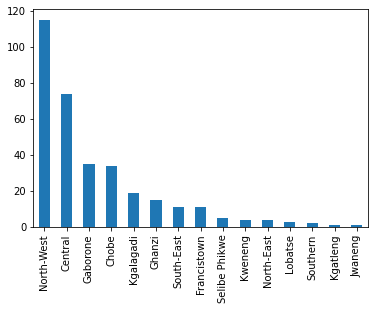

In [34]:
dffac['region'].value_counts().plot(kind='bar')

Lets go back to our patients now. I will first remove records with NaN gender.

In [35]:
def drop_null_gender(df):
    """
    Drop all records without gender field and reset index.
    """
    df.dropna(subset=['gender'], inplace=True)
    df = df.reset_index(drop=True)
    return df

In [36]:
dfp = drop_null_gender(dfp)
dfp.shape[0]

48998

In [37]:
dfp.isnull().sum().sum()

10586

In [38]:
dfp['fac_id'].isnull().sum()

2438

Now we will find indexes of those row and match them with our fac_id dataframe.

In [39]:
import pandas as pd
import numpy as np

In [40]:
index = dfp['fac_id'].index[dfp['fac_id'].apply(np.isnan)]
len(index)

2438

Since lat and long all unique for all facilities we can use one to match out fac_id.

In [41]:
def fill_missing_facid(df0, df1):
    """
    Since lat and long all unique for all facilities we 
    can use one to match out fac_id. Find index of NaN fac_id and 
    search facility ID dataframe for match on longitude.
    If there is no long, as we will assume no geo location
    was captured, remove records.
    df0: patient dataframe
    df1: facilities dataframe
    """
    ind = df0['fac_id'].index[df0['fac_id'].apply(np.isnan)]
    empty_idx = []
    for i in ind:
        long0 = df0.loc[i].long
        try:
            facid = df1[df1['long'] == long0]['fac_id'].values[0]
            df0.loc[i, 'fac_id'] = facid
        except IndexError:
            empty_idx.append(i)
    if empty_idx:
        df0 = df0.drop(df0.index[empty_idx])
        df0 = df0.reset_index(drop=True)
    return df0

In [42]:
dfp = fill_missing_facid(dfp, dffac)
dfp['fac_id'].isnull().sum() == 0

True

In [43]:
dfp.shape[0]

48801

In [44]:
dfp.isnull().sum().sum()

7740

Now we can remove offending facilities from earlier.

In [45]:
def remove_facilities(df0, df1):
    """
    Remove facilities from patient dataframe that are not present in 
    facilities dataframe
    df0: patient dataframe
    df1: facilities dataframe
    """
    bad_facid = list(set(list(df0['fac_id'].unique())) - set(list(df1['fac_id'])))
    idx = [df0[df0['fac_id'] == i].index.tolist() for i in bad_facid]
    bad_idx = [item for sublist in idx for item in sublist]
    
    df0.drop(df0.index[bad_idx], inplace=True)
    df0 = df0.reset_index(drop=True)
    return df0

In [46]:
dfp = remove_facilities(dfp, dffac)
dfp.shape[0]

47282

In [47]:
dfp.isnull().sum().sum()

4538

Still NaNs... Now we can use facility ID to fill missing data!

In [48]:
def fill_missing_values(df0, df1):
    """
    Find index of NaN values. For each index read fac_id. 
    Using that fac_id read long, lat, region and district 
    from facilities dataframe and write them to patient dataframe.
    df0: patient dataframe
    df1: facilities dataframe
    """
    ind = df0[df0.isnull().any(axis=1)].index
    for i in ind:
        facid = df0.loc[i].fac_id
        df0.loc[i, 'long'] = df1[df1.fac_id == facid].long.values[0]
        df0.loc[i, 'lat']  = df1[df1.fac_id == facid].lat.values[0]
        df0.loc[i, 'region']  = df1[df1.fac_id == facid].region.values[0]
        df0.loc[i, 'district'] = df1[df1.fac_id == facid].district.values[0]
    return df0

In [49]:
dfp = fill_missing_values(dfp, dffac)
dfp.isnull().sum().sum() == 0

True

In [50]:
50000 - dfp.shape[0]

2718

Now wrap it all in one function to create `preprocessed_patients` dataset.

## Immunization

Data Dictionary: immunizations_db.csv
* pat_id: The ID of the child.
* vaccine: The abbreviated name of the vaccine the child attempted to receive.
* im_date: Immunization date, i.e. the date the child received the vaccine.
* successful: Whether or not the vaccination was successful.
* reason_unsuccesful: If the vaccination was unsuccessful, the selected reason why.

* OPV (oral polio vaccine):
    * Dose 1: birth
    * Dose 2: 6 weeks
    * Dose 3: 10 weeks,
    * Dose 4: 14 weeks*
* DTP (diphtheria, tetanus, pertussis)​:
    * Dose 1: 6 weeks
    * Dose 2: 10 weeks
    * Dose 3: 14 weeks*

In [51]:
dfi = catalog.load("immunization")
dfi.head()

2020-06-07 22:48:03,334 - kedro.io.data_catalog - INFO - Loading data from `immunization` (CSVDataSet)...


,Unnamed: 0,pat_id,vaccine,im_date,successful,reason_unsuccesful
0,0,1,OPV,2019-01-31,True,NaN
1,1,2,OPV,2019-11-12,True,NaN
2,2,3,OPV,2019-11-03,True,NaN
3,3,4,OPV,2019-06-01,True,NaN
4,4,5,OPV,2018-12-24,True,NaN


In [52]:
dfi.isnull().sum().sum()

273865

In [53]:
def remove_unnamed_column_immunization(df):
    """
    Remove columns leftover by df to csv conversion.
    """
    return df.drop('Unnamed: 0', 1)

In [54]:
dfi = remove_unnamed_column_immunization(dfi)
dfi.shape

(276764, 5)

In [55]:
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276764 entries, 0 to 276763
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   pat_id              276764 non-null  int64 
 1   vaccine             276764 non-null  object
 2   im_date             276764 non-null  object
 3   successful          276764 non-null  bool  
 4   reason_unsuccesful  2899 non-null    object
dtypes: bool(1), int64(1), object(3)
memory usage: 8.7+ MB


In [56]:
dfi.dtypes

pat_id                 int64
vaccine               object
im_date               object
successful              bool
reason_unsuccesful    object
dtype: object

From the `reason_unsuccesful` it looks like the child was not vaccinated, but was present at the clinic so the healtcare proffesional could make the call to vaccinate or not. Two out of four reasons are about supply chain, one is medical reason and one, `StartedLate`, is related to the child "behaviour". Since the question is about children who are at `high_risk` of defaulting from a routine immunization program and require health worker intervention I am tempted to remove all `unsuccessful` records... If I had more time I would investigate those further to see how those affect the completion of immunization. At the moment they just skeewing my dataset.

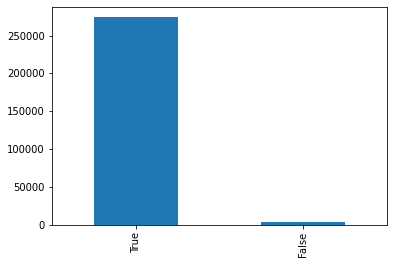

In [57]:
dfi['successful'].value_counts().plot(kind='bar')

In [58]:
dfi['successful'].value_counts()

True     273865
False      2899
Name: successful, dtype: int64

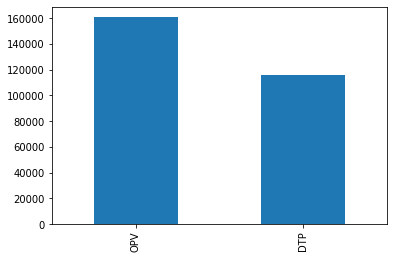

In [59]:
dfi['vaccine'].value_counts().plot(kind='bar')

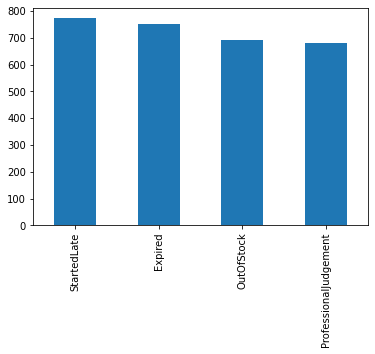

In [60]:
dfi['reason_unsuccesful'].value_counts().plot(kind='bar')

In [61]:
def convert_to_date(df):
    df['im_date'] = pd.to_datetime(df['im_date'], format='%Y-%m-%d')
    return df

In [62]:
def keep_successful(df):
    """
    Remove unsuccessful immunizations.
    """
    df = df[df.successful == True]
    return df

In [63]:
dfi = keep_successful(dfi)
dfi.shape

(273865, 5)

Remove `successful` and `reason_unsuccesful`

In [64]:
def remove_unsuccesful_columns(df):
    """
    Remove unsuccessful reason and succesful columns
    """
    return df.drop(['successful', 'reason_unsuccesful'], 1)

In [65]:
dfi = remove_unsuccesful_columns(dfi)

In [66]:
dfi = convert_to_date(dfi)
dfi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273865 entries, 0 to 276763
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   pat_id   273865 non-null  int64         
 1   vaccine  273865 non-null  object        
 2   im_date  273865 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 8.4+ MB


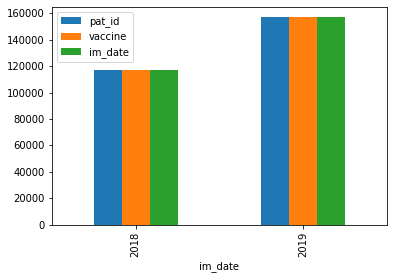

In [67]:
dfi.groupby(dfi["im_date"].dt.year).count().plot(kind="bar")

Dates look ok.

In [68]:
dfi['vaccine'].isnull().sum()

0

Check if there are any extra patients in `immunization` dataframe.

In [69]:
pat_list = list(dfp['pat_id'].unique())
len(pat_list)

47282

In [70]:
40 in pat_list

True

In [71]:
idx = [dfi[dfi['pat_id'] == i].index.tolist() for i in pat_list]
good_idx = [item for sublist in idx for item in sublist]
len(good_idx)

258964

In [72]:
dfi[dfi['pat_id'] == 40]

,pat_id,vaccine,im_date


In [73]:
dfi = dfi.loc[good_idx]
dfi.shape

(258964, 3)

In [74]:
dfi.head()

,pat_id,vaccine,im_date
0,1,OPV,2019-01-31
45075,1,OPV,2019-04-03
86788,1,OPV,2019-05-25
125363,1,OPV,2019-07-06
160792,1,DTP,2019-04-03


In [75]:
set(list(dfp.pat_id.unique())) == set(list(dfi.pat_id.unique()))

False

In [76]:
def remove_records(patient, immunization):
    """
    Remove records from immunization dataframe that correspond to unknown patients.
    df0: patient dataframe
    df1: immunization dataframe
    """    
    pat_list = list(patient['pat_id'].unique())
    idx = [immunization[immunization['pat_id'] == i].index.tolist() for i in pat_list]
    good_idx = [item for sublist in idx for item in sublist]
    
#     immunization = immunization.loc[good_idx]
    immunization = immunization[immunization.index.isin(good_idx)]
    immunization = immunization.reset_index(drop=True)
    return immunization

In [77]:
def preprocess_patients(df0, df1):
    """
    Bring all functions to create pre-processed df
    """
    df = remove_unnamed_column_patients(df0)
    df = drop_null_gender(df)
    df = fill_missing_facid(df, df1)
    df = remove_facilities(df, df1)
    df = fill_missing_values(df, df1)
    return df

In [78]:
dfp = catalog.load("patients")
dfp = preprocess_patients(dfp, dffac)

2020-06-07 22:48:36,500 - kedro.io.data_catalog - INFO - Loading data from `patients` (CSVDataSet)...


In [79]:
dfp.isnull().sum().sum()

0

In [80]:
50000 - dfp.shape[0]

2718

I removed about 6% of the data. This number could be improved with further investigation into geo location of the facilities.

In [81]:
def preprocess_immunization(immunization, preprocessed_patients):
    """
    Bring all functions to create pre-processed df
    """
    df = remove_unnamed_column_immunization(immunization)
    df = keep_successful(df)
    df = remove_unsuccesful_columns(df)
    return remove_records(preprocessed_patients, df)

In [82]:
dfi = catalog.load("immunization")
dfi = preprocess_immunization(dfi, dfp)

2020-06-07 22:48:47,431 - kedro.io.data_catalog - INFO - Loading data from `immunization` (CSVDataSet)...


In [83]:
dfi.isnull().sum().sum()

0

In [84]:
dfp.isnull().sum().sum()

0

This file doesn't need that much preprocessing attention. Lets move on to features.